# Introduction to keras

> Keras is a high-level neural networks API, written in Python and capable of running on top of either [TensorFlow](https://www.tensorflow.org),[CNTK](https://github.com/Microsoft/cntk) or  [Theano](https://github.com/Theano/Theano). It was developed with a focus on enabling fast experimentation. 
> _Being able to go from idea to result with the least possible delay is key to doing good research._

There are two ways to build Keras models:  _sequential_  and  _functional_.

The [Sequential API](https://keras.io/getting-started/sequential-model-guide/)  is a linear stack of layers. Only for single-input, single-output, it is fit for most of use cases.
It is limited in that it does not allow to create models that share layers or have multiple inputs or outputs.

Alternatively, the [Functional  API](https://keras.io/getting-started/functional-api-guide/) provides a more flexible way for defining models, allowing to connect layers to any other layer. This results in the definition of complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

The package offers many recipes to follow and many [examples](https://github.com/fchollet/keras/tree/master/examples) for problems in NLP and image classification.

The example below was originally published at [Mike Irvine's Blog](https://sempwn.github.io/blog/2017/03/24/keras_basic_intro)

## Toy dataset

We start by generating data using the [scikit learn library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [5]:
%pylab inline
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

Populating the interactive namespace from numpy and matplotlib


In [6]:
X.ndim

2

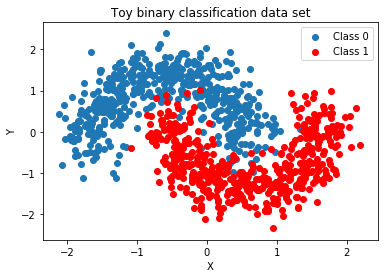

In [7]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

Our data has a binary class (0 or 1), with two input dimensions ($x$ and $y$) and is visualised above. In order 
to correctly classify the class the neural network will need to successfully separate out the zig-zag shape that intersects
where the two classes meet.

## Introduction to the Sequential API
Now we import the keras library as well as the `Sequential` model class which forms the basic skeleton for our neural network. We'll only consider one type of layer, where all the neurons in a layer are connected to all the other neurons in the previous layer.

 * Models can be instaniated using the `Sequential()` class. 
 * Neural networks are built up from bottom layer to top using the `add()` method.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [ ]:
# tf1 vs. tf2


In [3]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Defining the model

We'll create a very simple multi-layer perceptron with one hidden layer.

This is done in keras by first defining a `Sequential` class object. Layers are then added from the initial layer
that includes the data, so we need to specifiy the number of input dimensions using the keyword `input_dim`. We also define the acitvation of this layer to be a rectified linear unit `relu`. 

Finally a densely connected layer is added with one output and a `sigmoid` activation corresponding to the binary class.

In [8]:
# Create sequential  multi-layer perceptron
model = Sequential()

# The model expects rows of data with 2 variables input dimensions.
model.add(Dense(32, input_dim=X.ndim, activation='relu'))

# The output layer has one node and uses the sigmoid activation function.
model.add(Dense(1, activation='sigmoid')) 

## Compiling the model

Before training a model, we need to configure the learning process, that is, compiling the model.
The  `compile`  method uses the efficient numerical libraries under the covers (the so-called backend) such as Theano or TensorFlow. The backend automatically chooses the best way to represent the network for training and making predictions to run on your hardware, such as CPU or GPU or even distributed.

It expects the following parameters:
+ [optimizer](https://keras.io/optimizers), the optimization algorithm such as  `rmsprop`  or  `adagrad`
+ [loss function](https://keras.io/losses), the objective that the model will try to minimize such as  `categorical_crossentropy`  or  `mse`
+ any additional [metrics](https://keras.io/metrics) we want to consider.  For any classification problem we want to set this to  `metrics=['accuracy']`

In [8]:
model.compile(optimizer=keras.optimizers.Adadelta(),
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])

## Investigating the model

Let's see what we've constructed layer by layer:

+ **Confirm layer order**. It is easy to add layers in the wrong order with the sequential API or to connect them together incorrectly with the functional API. The graph plot can help you confirm that the model is connected the way you intended.
+ **Confirm the output shape of each layer**. It is common to have problems when defining the shape of input data for complex networks like convolutional and recurrent neural networks. The summary and plot can help you confirm the input shape to the network is as you intended.
+ **Confirm parameters**. Some network configurations can use far fewer parameters, such as the use of a TimeDistributed wrapped Dense layer in an Encoder-Decoder recurrent neural network. Reviewing the summary can help spot cases of using far more parameters than expected.

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


## Fitting the model

We have defined our model and compiled it ready for efficient computation.
Now it is time to execute the model on some data. Keras models are trained on Numpy arrays of input data and labels. 


The training process will run for a fixed number of iterations through of the rows in the dataset, that we must specify using the __epochs__ argument. 

We must also set the number of dataset rows that are considered before the model weights are updated within each epoch, called the batch size and set using the __batch_size__ argument.

Training occurs over epochs and each epoch is split into batches:
+ Epoch: One pass through all of the rows in the training dataset.
+ Batch: One or more samples considered by the model within an epoch before weights are updated.


For more on that, check out this post on [Machine Learning Mastery Blog](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

In [10]:
model.fit(X_train, Y_train, batch_size=32, epochs=200,
          verbose=0, validation_data=(X_test, Y_test))

## Evaluating the model

This will only give us an idea of how well we have modeled the dataset (e.g. train accuracy), but no idea of how well the algorithm might perform on new data. 

You can evaluate your model on your training dataset using the evaluate() function on your model and pass it the same input and output used to train the model.

This will generate a prediction for each input and output pair and collect scores, including the average loss and any metrics you have configured, such as accuracy.

In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1277289606332779
Test accuracy: 0.9539999961853027


## Plotting the model predictions across the grid
We can create a grid of $(x,y)$ values and then predict the class probability on each of these values using our fitted model. We'll then plot the original data with the underlying probabilities to see what the classification looks like and how it compares to the data.

More details about how to make predictions for classification and regression models can be found at the [Machine Learning Mastery Blog](https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/)

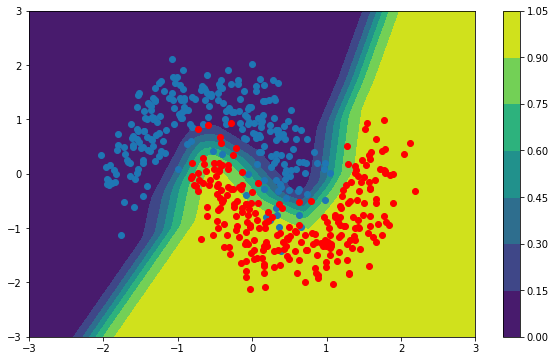

In [14]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X, Y = grid
prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)

fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, prediction_probs.reshape(100, 100))
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)

As we can see in the graph above, the model able to fully capture the zig-zag pattern to fully separate the classes. We could potentially experiment adding more layers or additional input ($xy$ for instance).

# Conclusion

This was a trivial example of the use of keras on some test data. The real power comes when we start to consider [convolutional](https://en.wikipedia.org/wiki/Convolutional_neural_network) or [recurrent](https://en.wikipedia.org/wiki/Long_short-term_memory) neural networks. 

More on this on the next notebooks.